In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
#why are we using a modulo operator ever?
#what is role of gpe_bl and gpi_bl, will likely require reading...

In [166]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops=n_loops

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.zeros((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold the inputs...
        self.a_inp = np.zeros((time_steps, n_loops)) 

        for i in range(10):
            self.a_inp[i] = [0.05,0.9,0.05]

        #variable to keep track of what step we are currently on
        self.c = 0




    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i, da):

        #likely easier to just define the parameters inside this function...
        
        dt = 0.001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the weight matrices
        w_inp_sp1 = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * 10
        w_inp_stn = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * 10
        w_ctx_sp1 = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * 0
        w_ctx_sp2 = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * 0
        w_ctx_stn = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * 0
        w_sd1_gpi = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * -15
        w_sd2_gpe = np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]) * -0
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 3
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0
        w_gpe_stn = np.ones((self.n_loops,self.n_loops)) * -1
        w_gpe_gpi = np.ones((self.n_loops,self.n_loops)) * -0.3
        w_gpi_tha = np.array([[0.8,0.1,0.1],[0.1,0.8,0.1],[0.1,0.1,0.8]]) * -10
        w_tha_ctx = np.array([[0.8,0.1,0.1],[0.1,0.8,0.1],[0.1,0.1,0.8]]) * 15


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 1
        sd2_bl = 0.1
        sd2_DA = 20
        gpi_bl = 0.1
        gpe_bl = 0.1
        
        #(self.a_ctx[0]) = [0.1,0.5,0.1]

        #input to sd1 from cortex modulated by dopamine, this completes the loop
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * da) * (np.matmul(self.a_ctx[i], w_ctx_sp1)+ np.matmul(self.a_inp[i], w_inp_sp1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * da)) * (np.matmul(self.a_ctx[i], w_ctx_sp2)))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], w_ctx_stn)) + np.matmul(self.a_gpe[i], w_gpe_stn)) + (np.matmul(self.a_inp[i], w_inp_stn)))

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i]) + (np.matmul(self.a_sd2[i], w_sd2_gpe)) + (np.matmul(self.a_stn[i], w_stn_gpe)))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_sd1[i], w_sd1_gpi))   + (np.matmul(self.a_stn[i], w_stn_gpi)) + (np.matmul(self.a_gpe[i], w_gpe_gpi)) + 7))

        #input to gpi from 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_gpi[i], w_gpi_tha)) + 7))

        #input to cortex from gpi, also going to give some tonic excitation
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.a_tha[i], w_tha_ctx))))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(1*(vec)+0)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps):
        
        for i in range(steps):
            self.step(i=self.c,da=1)

    def display(self):
        
        plt.figure()
        plt.plot(self.a_inp)

        plt.figure()
        plt.plot(self.a_sd1)

        plt.figure()
        plt.plot(self.a_gpi)

        plt.figure()
        plt.plot(self.a_tha)

        plt.figure()
        plt.plot(self.a_ctx)

        return None



[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.71947304 0.71947304 0.71947304]
 [0.         0.         0.        ]
 [0.02891559 0.22734617 0.02891559]
 [0.02053176 0.16320245 0.02053176]
 [0.02202728 0.17454618 0.02202728]
 [0.02181146 0.17293112 0.02181146]
 [0.02183926 0.17313617 0.02183926]
 [0.02183592 0.17311189 0.02183592]
 [0.0218363  0.17311464 0.0218363 ]
 [0.02183626 0.17311434 0.02183626]
 [0.02183627 0.17311437 0.02183627]
 [0.02183627 0.17311436 0.02183627]
 [0.13202413 0.09450193 0.13202413]
 [0.09905832 0.10430902 0.09905832]
 [0.10382503 0.10320134 0.10382503]
 [0.10325148 0.10332026 0.10325148]
 [0.10331515 0.10330786 0.10331515]
 [0.10330838 0.10330913 0.10330838]
 [0.10330908 0.103309   0.10330908]
 [0.10330901 0.10330902 0.10330901]
 [0.10330902 0.10330901 0.10330902]
 [0.10330901 0.10330901 0.10330901]
 [0.10330901 0.10330901 0.10330901]
 [0.10330901 0.10330901 0.10330901]
 [0.10330901 0.10330901 0.10330901]
 [0.10330901 0.10330901 0.10

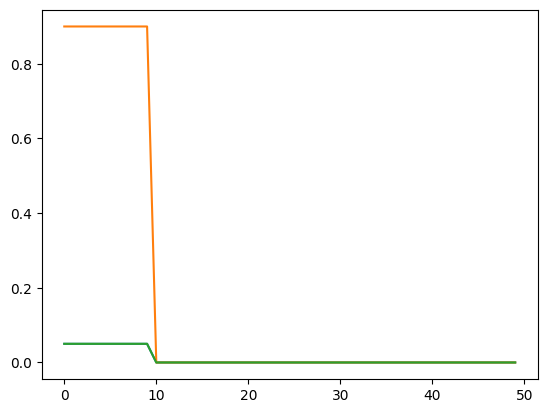

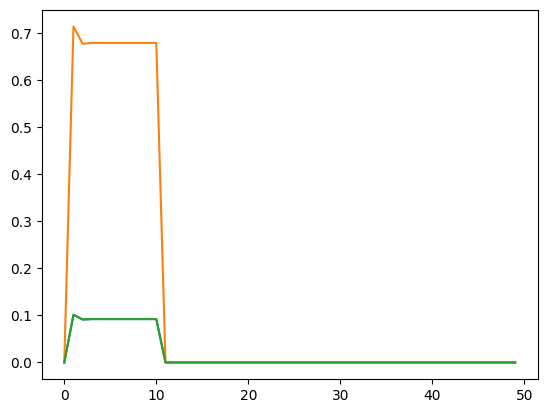

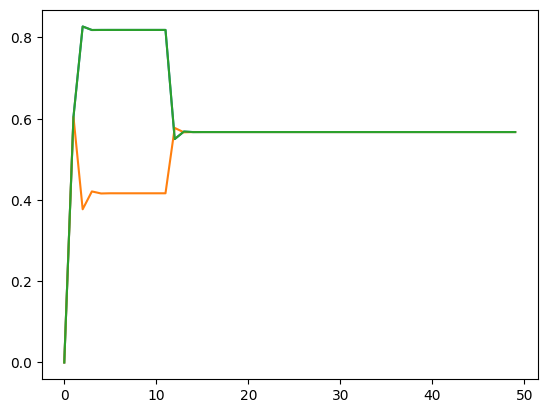

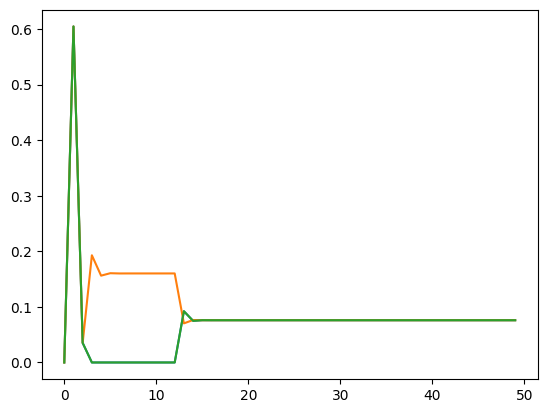

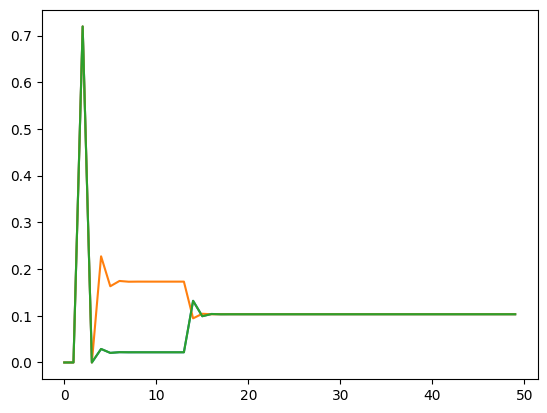

In [167]:
bg = b_ganglia(3,50)

bg.run(49)
print(bg.a_ctx)
bg.display()


